In [1]:
import os
import csv
import json
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import OrderedDict

import shap
shap.initjs()

In [2]:
def read_data(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter="\t")

    X = []
    Y = []
    i = 0
    print('Reading articles...')
    for row in read_tsv:
        #print(row)
        # Opening JSON file
        if(row[0][:]!='ID'):

            #if(i%1000==0):
            #    print('Reading article ', i)

            json_file = open('data/jsons/'+row[0][:]+'.json',)
            #print(row[1][:])
            # Reading JSON file
            data = json.load(json_file)

            Y.append(data['bias'])
            X.append(data['content'])


            #print(target)
            #print(text)

            # Closing file
            json_file.close()
            i = i + 1

    tsv_file.close()
    print('done')
    
    return X, Y


In [3]:
print('Load training dataset')
train_data_path = "data/splits/random/train.tsv"
X_train, Y_train = read_data(train_data_path)

# dictionary of lists 
dict_train = {'content': X_train, 'bias': Y_train} 
train_df = pd.DataFrame(dict_train)
#df_train.to_csv('data/splits/media/train_data.tsv', index=False)

print('Load validation dataset')
val_data_path = "data/splits/random/valid.tsv"
X_val, Y_val = read_data(val_data_path)

# dictionary of lists 
dict_val = {'content': X_val, 'bias': Y_val} 
val_df = pd.DataFrame(dict_val)
#df_val.to_csv('data/splits/media/val_data.tsv', index=False)

print('Load test dataset')
test_data_path = "data/splits/random/test.tsv"
X_test, Y_test = read_data(test_data_path)

# dictionary of lists 
dict_test = {'content': X_test, 'bias': Y_test} 
test_df = pd.DataFrame(dict_test)

#df_test.to_csv('data/splits/media/test_data.tsv', index=False)


Load training dataset
Reading articles...
done
Load validation dataset
Reading articles...
done
Load test dataset
Reading articles...
done


In [4]:
print("Train shape : ", train_df.shape)
print("Val shape : ", val_df.shape)
print("Test shape : ", test_df.shape)

Train shape :  (27978, 2)
Val shape :  (6996, 2)
Test shape :  (1300, 2)


In [5]:
## vectorize to tf-idf vectors
tfidf_vc = TfidfVectorizer(min_df = 3, max_features = 100000, sublinear_tf=True, encoding='latin-1', norm='l2', analyzer = "word", ngram_range = (1, 2), stop_words = 'english', lowercase = True)
train_vc = tfidf_vc.fit_transform(train_df["content"])
val_vc = tfidf_vc.transform(val_df["content"])
test_vc = tfidf_vc.transform(test_df["content"])

## LogisticRegression

In [6]:
import torch

In [7]:
torch.cuda.is_available()

True

In [8]:
model = LogisticRegression(C=1, max_iter=1000, solver = "lbfgs", class_weight='balanced', verbose=True)
model = model.fit(train_vc, train_df.bias)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min finished


In [9]:
train_pred = model.predict(train_vc)
val_pred = model.predict(val_vc)

In [10]:
from sklearn.metrics import f1_score
train_cv = f1_score(train_df.bias, train_pred, average = "macro")
print(train_cv)
val_cv = f1_score(val_df.bias, val_pred, average = "macro")
print(val_cv)

0.9297980750610026
0.7632486534881284


In [11]:
test_pred = model.predict(test_vc)
test_cv = f1_score(test_df.bias, test_pred, average = "macro")
print(test_cv)

0.7326935637975263


# Explain prediction using SHAP

In [19]:
explainer = shap.LinearExplainer(model, train_vc, feature_perturbation="interventional")
shap_values = explainer.shap_values(test_vc)
X_test_array = test_vc.toarray() # we need to pass a dense version for the plotting functions

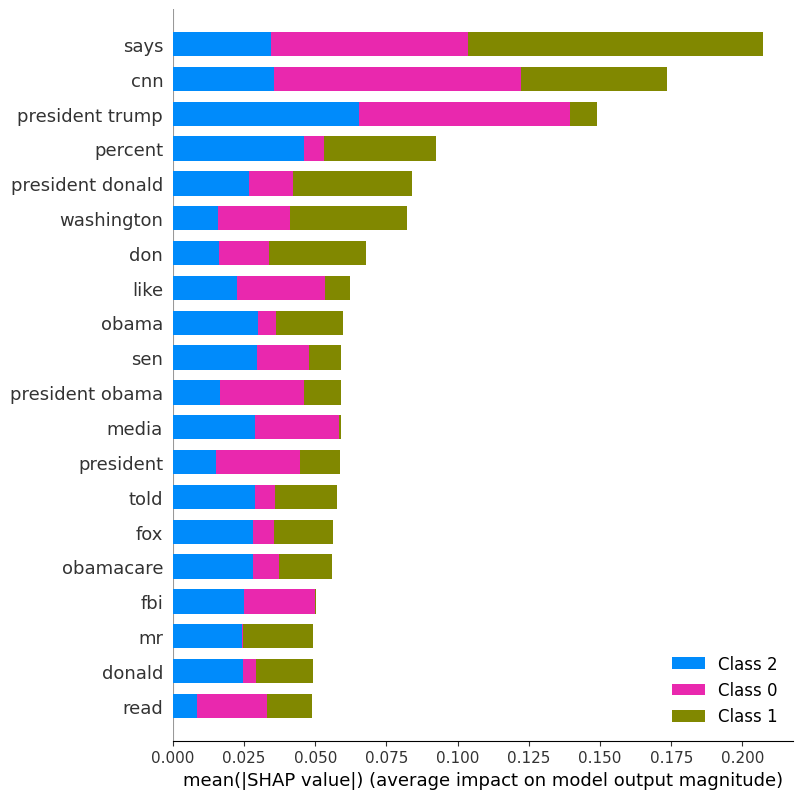

In [13]:
shap.summary_plot(shap_values, X_test_array, feature_names=tfidf_vc.get_feature_names())

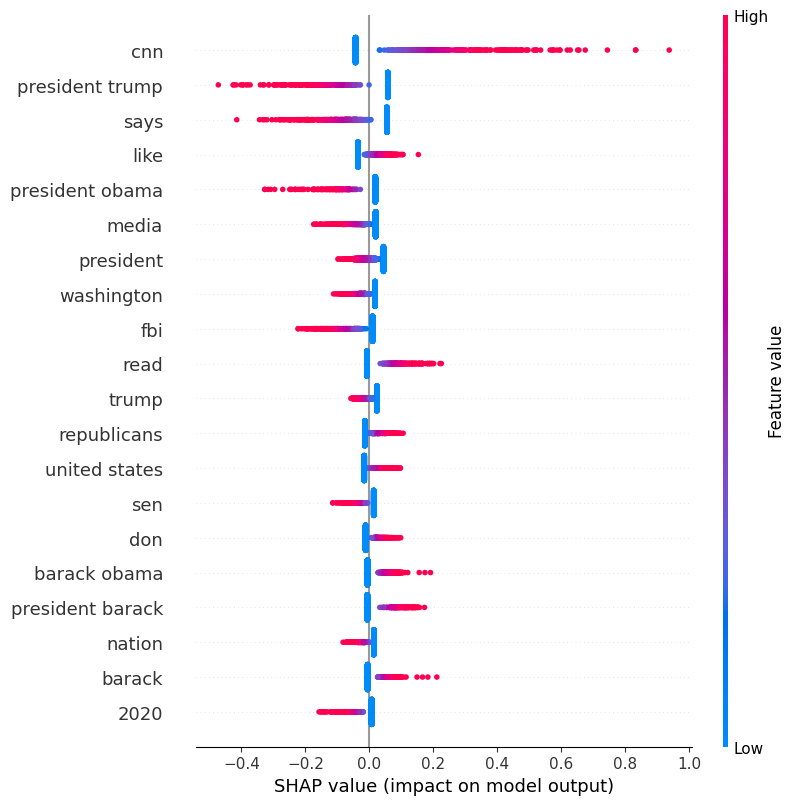

In [14]:
shap.summary_plot(shap_values[0], X_test_array, feature_names=tfidf_vc.get_feature_names())

In [15]:
ind = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][ind,:], X_test_array[ind,:], feature_names=tfidf_vc.get_feature_names())

In [16]:
print(test_df.bias[ind])
print(test_df["content"][ind])

2
For the last several days , the entire Western media has run with a false story : the story that Israeli Prime Minister Benjamin Netanyahu said he no longer would , under any circumstances , endorse the possibility of a Palestinian state .
Ha ’ aretz , a left-wing Israeli newspaper opposing Netanyahu , reported Netanyahu ’ s supposed comment with this headline : “ Netanyahu : If I ’ m Elected , There Will Be No Palestinian State. ” The rest of the media quickly followed . Days later , when Netanyahu said that he had never disavowed his prior support for the possibility of a Palestinian state – support he expressed in a speech at Bar Ilan University in 2009 – the media accused Netanyahu of flip-flopping .
There is only one problem : Netanyahu never said that a Palestinian state was out of the question .
The interview in which Netanyahu expressed the much-misinterpreted remark took place with the conservative Israeli publication NRG . It also took place in Hebrew , a language virtually

In [17]:
ind = 1
shap.force_plot(
    explainer.expected_value[0], shap_values[0][ind,:], X_test_array[ind,:],
    feature_names=tfidf_vc.get_feature_names()
)

In [18]:
print(test_df.bias[ind])
print(test_df.content[ind])

0
Tomorrow morning , House Budget Chairman Paul Ryan will release the latest version of his budget blueprint , setting the federal government on a course to balance annual revenue and spending levels by the year 2023 .
Until now , the former Republican vice presidential nominee has never proposed a budget that balanced in just a decade .
`` I would n't expect big surprises from us [ Tuesday ] . We 're making some additional modest changes to get to balance . '' Ryan , R-Wis. , told reporters at briefing last week . `` We 're adding some other policies that finish the job , but I would n't expect big surprises from us next week . I do n't want to set irrational expectations . ''
This time , Ryan points to two unlikely factors that actually help achieve the conservative goal : revenue and sequestration .
`` Revenue went up significantly two months ago with the `` Fiscal Cliff '' deal . The baselines changed . We 're not going to refight that fight , '' Ryan said , referring to $ 600 bill